# MODELISATION - CHURN PREDICTION FORTUNEO BANQUE

### **Objectif**: Construire et optimiser des modeles de classification pour predire le churn

### **Approche**:
#### 1. Baseline models (Logistic Regression)
#### 2. Modeles avances (RF, XGBoost, LightGBM, CatBoost)
#### 3. Pipelines sklearn
#### 4. Cross-validation
#### 5. Optimisation des hyperparametres
#### 6. Comparaison et selection du meilleur modele


## Importation des library

In [6]:
import os 
os.getcwd()

'C:\\Users\\Easy Services Pro\\Projet_Machine_Learning2\\notebooks'

In [1]:
### IMPORTATION DES BIBLIOTHEQUES

# Data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - Preprocessing & Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Sklearn - Model Selection
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)

# Sklearn - Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve
)

# Sklearn - Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("Warning: XGBoost not available")

# LightGBM
try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("Warning: LightGBM not available")

# CatBoost
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("Warning: CatBoost not available")

# Utils
import joblib
import time
from pathlib import Path

In [3]:
# Configuration
np.random.seed(42)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("Bibliotheques importees avec succes!")

Bibliotheques importees avec succes!


## CHARGEMENT DES DONNEES PREPROCESSEES

In [5]:
# Detecter le chemin de base
current_path = Path.cwd()
if current_path.name == 'notebooks':
    base_path = current_path.parent
else:
    base_path = current_path

processed_path = base_path / 'data' / 'processed'

print("="*60)
print("CHARGEMENT DES DONNEES PREPROCESSEES")
print("="*60)

CHARGEMENT DES DONNEES PREPROCESSEES


In [7]:
# Charger les donnees
X_train = pd.read_csv(processed_path / 'X_train.csv')
X_val = pd.read_csv(processed_path / 'X_val.csv')
X_test = pd.read_csv(processed_path / 'X_test.csv')
y_train = pd.read_csv(processed_path / 'y_train.csv')['Exited']
y_val = pd.read_csv(processed_path / 'y_val.csv')['Exited']

print(f"\nTrain set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

print(f"\nDistribution Train:")
print(y_train.value_counts())
print(f"\nDistribution Validation:")
print(y_val.value_counts())


Train set: (208180, 24)
Validation set: (52046, 24)
Test set: (110023, 24)

Distribution Train:
Exited
1    104090
0    104090
Name: count, dtype: int64

Distribution Validation:
Exited
0    26023
1    26023
Name: count, dtype: int64


In [11]:
# Informations sur les features
print(f"\nNombre de features: {X_train.shape[1]}")
print(f"\nListe des features:")
for i, col in enumerate(X_train.columns, 1):
    print(f"  {i:2d}. {col}")


Nombre de features: 24

Liste des features:
   1. CreditScore
   2. Gender
   3. Age
   4. Tenure
   5. Balance
   6. NumOfProducts
   7. HasCrCard
   8. IsActiveMember
   9. EstimatedSalary
  10. BalanceSalaryRatio
  11. IsZeroBalance
  12. HasMultipleProducts
  13. EngagementScore
  14. Age_Balance_Interaction
  15. TenureAgeRatio
  16. Geography_Germany
  17. Geography_Spain
  18. AgeGroup_Adult
  19. AgeGroup_Middle
  20. AgeGroup_Senior
  21. TenureGroup_Regular
  22. TenureGroup_Loyal
  23. CreditScoreGroup_Good
  24. CreditScoreGroup_Excellent


### FONCTIONS UTILITAIRES

In [13]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name="Model"):
    """
    Evalue un modele sur train et validation
    
    Args:
        model: Modele sklearn
        X_train, y_train: Donnees d'entrainement
        X_val, y_val: Donnees de validation
        model_name: Nom du modele
    
    Returns:
        dict avec les metriques
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Probabilites
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    # Metriques
    results = {
        'model_name': model_name,
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'val_accuracy': accuracy_score(y_val, y_val_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'val_precision': precision_score(y_val, y_val_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'val_recall': recall_score(y_val, y_val_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'val_f1': f1_score(y_val, y_val_pred),
        'train_roc_auc': roc_auc_score(y_train, y_train_proba),
        'val_roc_auc': roc_auc_score(y_val, y_val_proba)
    }
    
    return results

In [15]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Affiche la matrice de confusion"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Reste (0)', 'Parti (1)'],
                yticklabels=['Reste (0)', 'Parti (1)'])
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Valeur Reelle')
    plt.xlabel('Valeur Predite')
    plt.tight_layout()
    plt.show()

In [17]:
def plot_roc_curve(y_true, y_proba, model_name="Model"):
    """Affiche la courbe ROC"""
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    auc_score = roc_auc_score(y_true, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Courbe ROC', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [19]:
def plot_feature_importance(model, feature_names, top_n=20, model_name="Model"):
    """Affiche l'importance des features"""
    
    # Extraire l'importance selon le type de modele
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        print("Modele ne supporte pas l'importance des features")
        return
    
    # Creer un DataFrame
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Afficher le top N
    top_features = feature_imp.head(top_n)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top {top_n} Features - {model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return feature_imp

In [21]:
def compare_models(results_list):
    """
    Compare les performances de plusieurs modeles
    
    Args:
        results_list: Liste de dictionnaires de resultats
    
    Returns:
        DataFrame de comparaison
    """
    df = pd.DataFrame(results_list)
    
    # Calculer l'overfitting
    df['overfit_accuracy'] = df['train_accuracy'] - df['val_accuracy']
    df['overfit_f1'] = df['train_f1'] - df['val_f1']
    
    return df

### BASELINE MODEL - LOGISTIC REGRESSION

In [23]:
print("="*60)
print("BASELINE MODEL - LOGISTIC REGRESSION")
print("="*60)

BASELINE MODEL - LOGISTIC REGRESSION


In [25]:
# Entrainer le modele baseline
baseline_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)
baseline_model

LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

In [27]:
print("\nEntrainement du modele baseline...")
start_time = time.time()
baseline_model.fit(X_train, y_train)
train_time = time.time() - start_time

print(f"Temps d'entrainement: {train_time:.2f} secondes")


Entrainement du modele baseline...
Temps d'entrainement: 5.73 secondes


In [29]:
# Evaluation
baseline_results = evaluate_model(
    baseline_model, X_train, y_train, X_val, y_val,
    model_name="Logistic Regression"
)

print("\n--- RESULTATS BASELINE ---")
print(f"Train Accuracy: {baseline_results['train_accuracy']:.4f}")
print(f"Val Accuracy:   {baseline_results['val_accuracy']:.4f}")
print(f"Train F1:       {baseline_results['train_f1']:.4f}")
print(f"Val F1:         {baseline_results['val_f1']:.4f}")
print(f"Train ROC-AUC:  {baseline_results['train_roc_auc']:.4f}")
print(f"Val ROC-AUC:    {baseline_results['val_roc_auc']:.4f}")


--- RESULTATS BASELINE ---
Train Accuracy: 0.8127
Val Accuracy:   0.8137
Train F1:       0.8142
Val F1:         0.8144
Train ROC-AUC:  0.8913
Val ROC-AUC:    0.8903


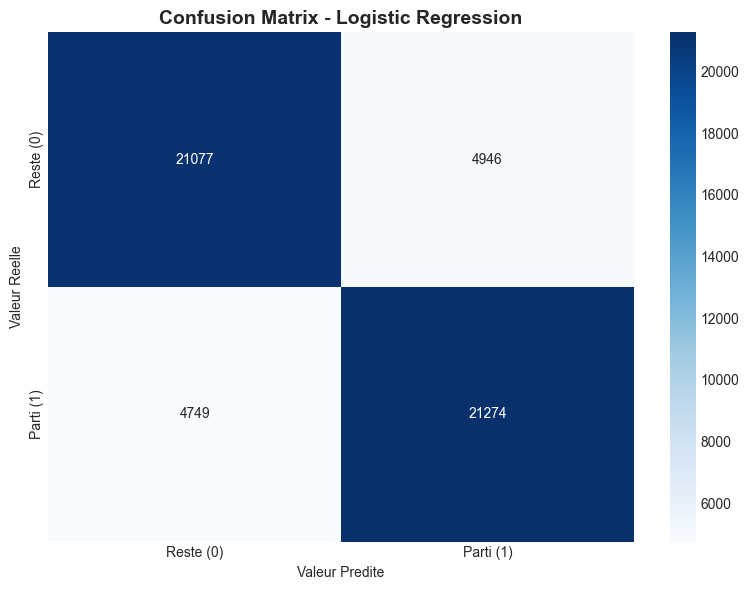

In [31]:
# Matrice de confusion
y_val_pred_baseline = baseline_model.predict(X_val)
plot_confusion_matrix(y_val, y_val_pred_baseline, 
                     title="Confusion Matrix - Logistic Regression")

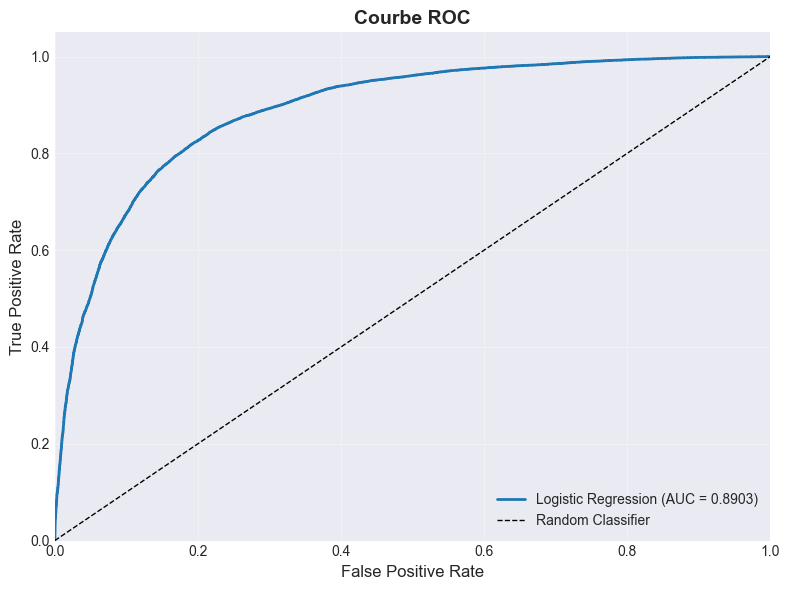

In [33]:
# Courbe ROC
y_val_proba_baseline = baseline_model.predict_proba(X_val)[:, 1]
plot_roc_curve(y_val, y_val_proba_baseline, model_name="Logistic Regression")

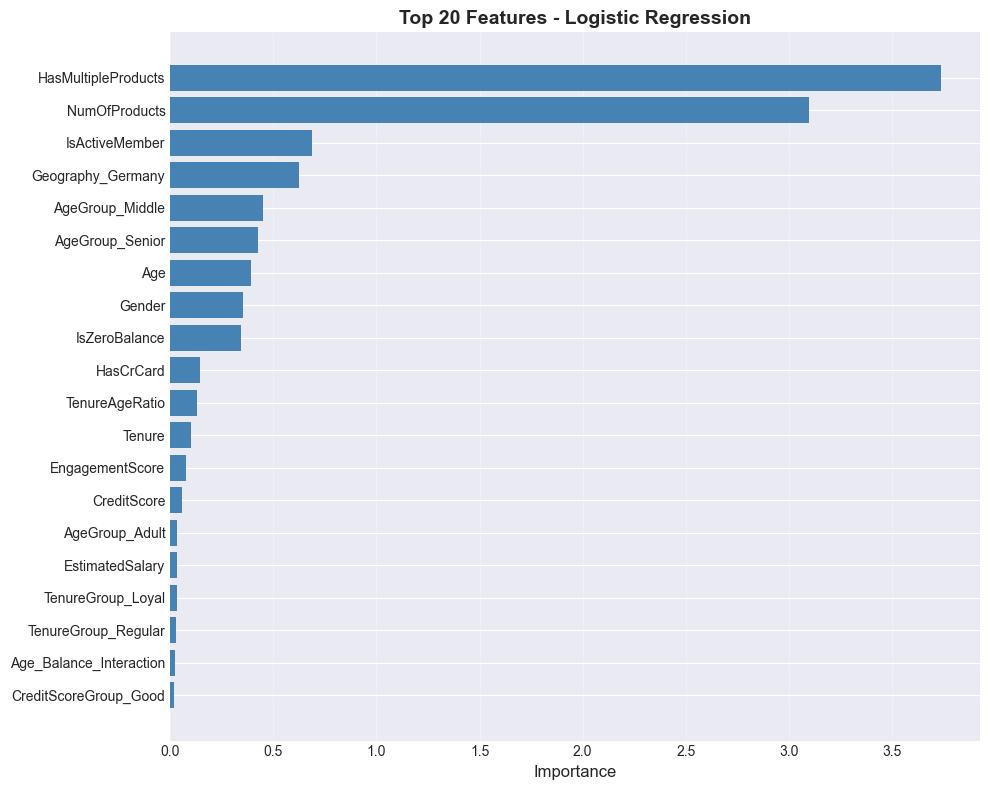


Top 10 Features les plus importantes:


,feature,importance
11,HasMultipleProducts,3.739613
5,NumOfProducts,3.095477
7,IsActiveMember,0.687507
15,Geography_Germany,0.623440
18,AgeGroup_Middle,0.449972
19,AgeGroup_Senior,0.424577
2,Age,0.391207
1,Gender,0.351443
10,IsZeroBalance,0.345383
6,HasCrCard,0.143638


In [35]:
# Feature importance
baseline_feature_imp = plot_feature_importance(
    baseline_model, 
    X_train.columns, 
    top_n=20,
    model_name="Logistic Regression"
)

print("\nTop 10 Features les plus importantes:")
display(baseline_feature_imp.head(10))

### MODELES AVANCES

In [37]:
# Dictionnaire pour stocker tous les resultats
all_results = [baseline_results]
trained_models = {'Logistic Regression': baseline_model}

#### Random Forest

In [39]:
print("="*60)
print("RANDOM FOREST CLASSIFIER")
print("="*60)

RANDOM FOREST CLASSIFIER


In [41]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_model

RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                       n_jobs=-1, random_state=42)

In [43]:
print("\nEntrainement du Random Forest...")
start_time = time.time()
rf_model.fit(X_train, y_train)
train_time = time.time() - start_time

print(f"Temps d'entrainement: {train_time:.2f} secondes")


Entrainement du Random Forest...
Temps d'entrainement: 35.38 secondes


In [45]:
# Evaluation
rf_results = evaluate_model(
    rf_model, X_train, y_train, X_val, y_val,
    model_name="Random Forest"
)

print("\n--- RESULTATS RANDOM FOREST ---")
print(f"Train Accuracy: {rf_results['train_accuracy']:.4f}")
print(f"Val Accuracy:   {rf_results['val_accuracy']:.4f}")
print(f"Train F1:       {rf_results['train_f1']:.4f}")
print(f"Val F1:         {rf_results['val_f1']:.4f}")
print(f"Train ROC-AUC:  {rf_results['train_roc_auc']:.4f}")
print(f"Val ROC-AUC:    {rf_results['val_roc_auc']:.4f}")


--- RESULTATS RANDOM FOREST ---
Train Accuracy: 0.9342
Val Accuracy:   0.9122
Train F1:       0.9322
Val F1:         0.9091
Train ROC-AUC:  0.9873
Val ROC-AUC:    0.9682


In [47]:
all_results.append(rf_results)
trained_models['Random Forest'] = rf_model

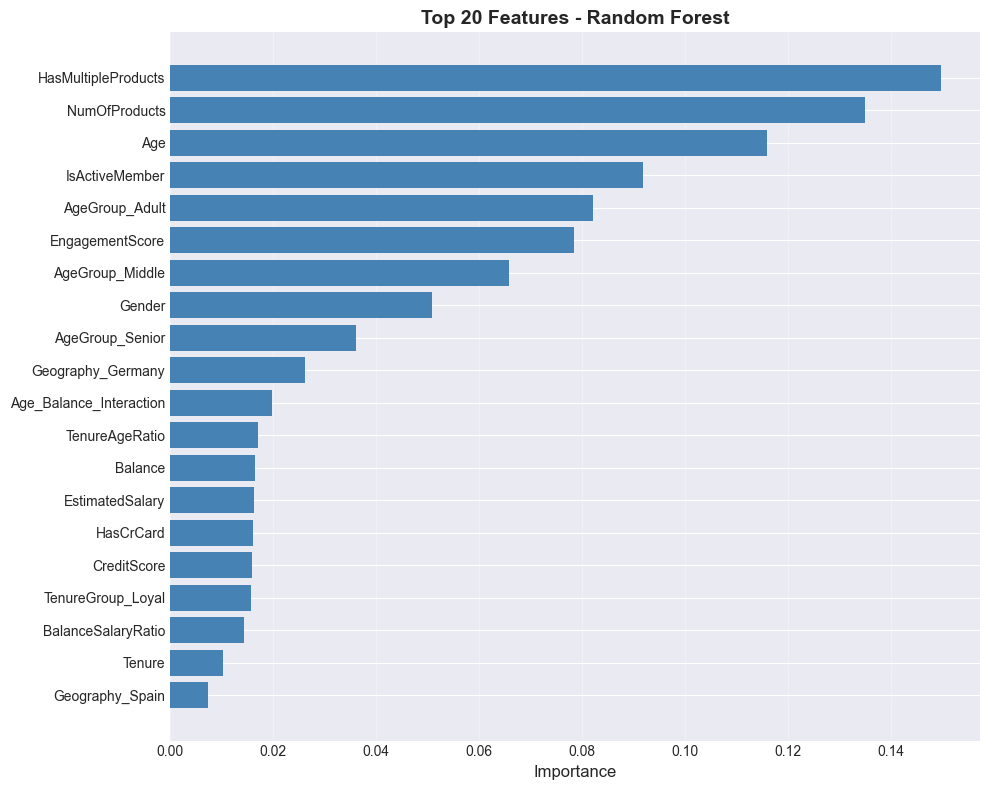

In [49]:
# Feature importance
rf_feature_imp = plot_feature_importance(
    rf_model, 
    X_train.columns, 
    top_n=20,
    model_name="Random Forest"
)

#### Gradient Boosting

In [51]:
print("="*60)
print("GRADIENT BOOSTING CLASSIFIER")
print("="*60)

GRADIENT BOOSTING CLASSIFIER


In [53]:
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    verbose=0
)
gb_model

GradientBoostingClassifier(max_depth=5, min_samples_leaf=4,
                           min_samples_split=10, random_state=42)

In [55]:
print("\nEntrainement du Gradient Boosting...")
start_time = time.time()
gb_model.fit(X_train, y_train)
train_time = time.time() - start_time

print(f"Temps d'entrainement: {train_time:.2f} secondes")


Entrainement du Gradient Boosting...
Temps d'entrainement: 345.55 secondes


In [57]:
# Evaluation
gb_results = evaluate_model(
    gb_model, X_train, y_train, X_val, y_val,
    model_name="Gradient Boosting"
)

print("\n--- RESULTATS GRADIENT BOOSTING ---")
print(f"Train Accuracy: {gb_results['train_accuracy']:.4f}")
print(f"Val Accuracy:   {gb_results['val_accuracy']:.4f}")
print(f"Train F1:       {gb_results['train_f1']:.4f}")
print(f"Val F1:         {gb_results['val_f1']:.4f}")
print(f"Train ROC-AUC:  {gb_results['train_roc_auc']:.4f}")
print(f"Val ROC-AUC:    {gb_results['val_roc_auc']:.4f}")

all_results.append(gb_results)
trained_models['Gradient Boosting'] = gb_model


--- RESULTATS GRADIENT BOOSTING ---
Train Accuracy: 0.9154
Val Accuracy:   0.9130
Train F1:       0.9126
Val F1:         0.9099
Train ROC-AUC:  0.9711
Val ROC-AUC:    0.9693


#### XGBoost

XGBOOST CLASSIFIER

Entrainement de XGBoost...
Temps d'entrainement: 3.95 secondes

--- RESULTATS XGBOOST ---
Train Accuracy: 0.9150
Val Accuracy:   0.9122
Train F1:       0.9122
Val F1:         0.9091
Train ROC-AUC:  0.9713
Val ROC-AUC:    0.9692


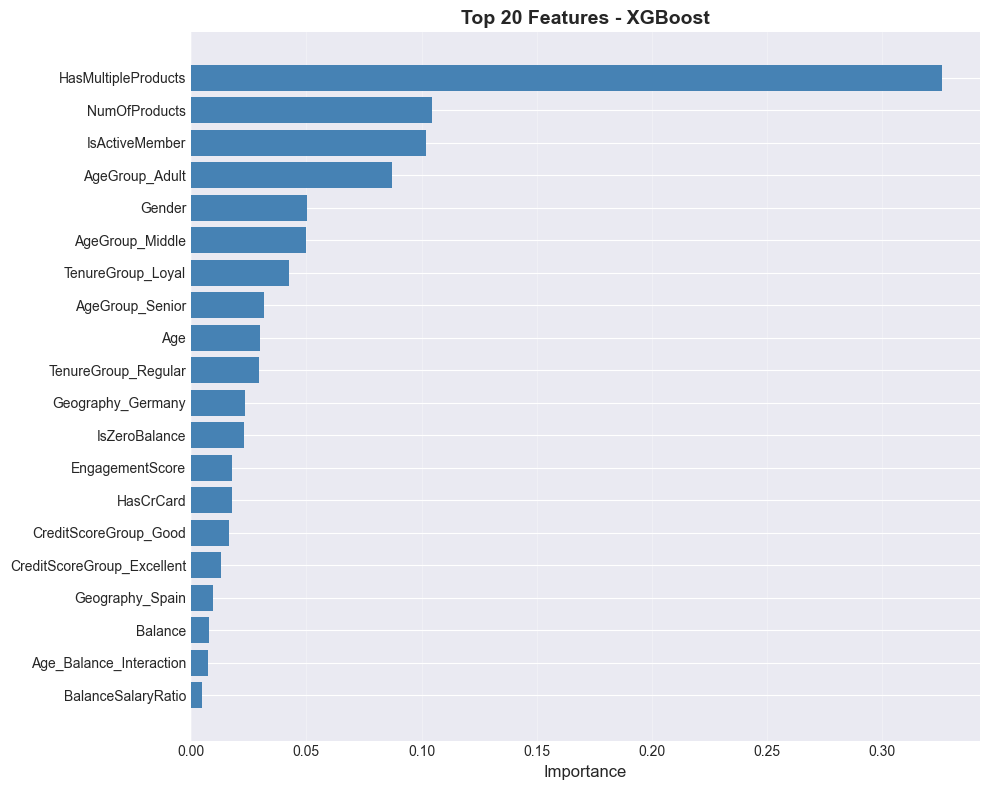

In [59]:
if XGBOOST_AVAILABLE:
    print("="*60)
    print("XGBOOST CLASSIFIER")
    print("="*60)
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
    
    print("\nEntrainement de XGBoost...")
    start_time = time.time()
    xgb_model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    print(f"Temps d'entrainement: {train_time:.2f} secondes")
    
    # Evaluation
    xgb_results = evaluate_model(
        xgb_model, X_train, y_train, X_val, y_val,
        model_name="XGBoost"
    )
    
    print("\n--- RESULTATS XGBOOST ---")
    print(f"Train Accuracy: {xgb_results['train_accuracy']:.4f}")
    print(f"Val Accuracy:   {xgb_results['val_accuracy']:.4f}")
    print(f"Train F1:       {xgb_results['train_f1']:.4f}")
    print(f"Val F1:         {xgb_results['val_f1']:.4f}")
    print(f"Train ROC-AUC:  {xgb_results['train_roc_auc']:.4f}")
    print(f"Val ROC-AUC:    {xgb_results['val_roc_auc']:.4f}")
    
    all_results.append(xgb_results)
    trained_models['XGBoost'] = xgb_model
    
    # Feature importance
    xgb_feature_imp = plot_feature_importance(
        xgb_model, 
        X_train.columns, 
        top_n=20,
        model_name="XGBoost"
    )
else:
    print("XGBoost non disponible. Installation: pip install xgboost")

#### LightGBM

LIGHTGBM CLASSIFIER

Entrainement de LightGBM...
Temps d'entrainement: 3.97 secondes

--- RESULTATS LIGHTGBM ---
Train Accuracy: 0.9152
Val Accuracy:   0.9131
Train F1:       0.9123
Val F1:         0.9100
Train ROC-AUC:  0.9714
Val ROC-AUC:    0.9694


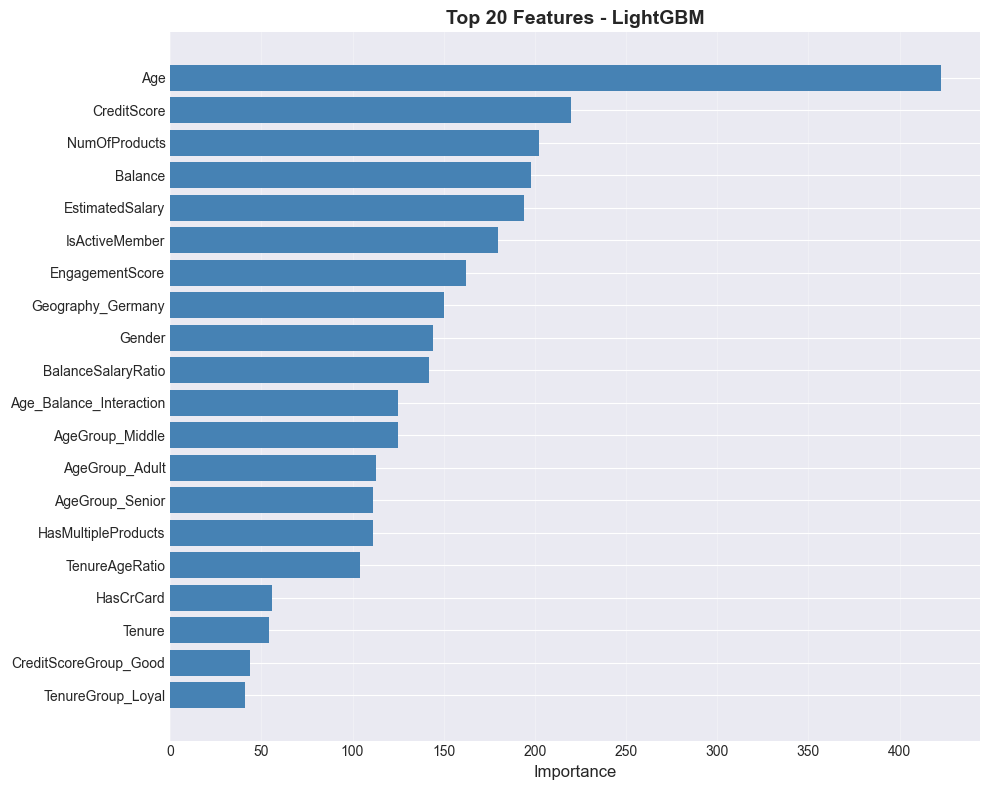

In [61]:
if LIGHTGBM_AVAILABLE:
    print("="*60)
    print("LIGHTGBM CLASSIFIER")
    print("="*60)
    
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    print("\nEntrainement de LightGBM...")
    start_time = time.time()
    lgb_model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    print(f"Temps d'entrainement: {train_time:.2f} secondes")
    
    # Evaluation
    lgb_results = evaluate_model(
        lgb_model, X_train, y_train, X_val, y_val,
        model_name="LightGBM"
    )
    
    print("\n--- RESULTATS LIGHTGBM ---")
    print(f"Train Accuracy: {lgb_results['train_accuracy']:.4f}")
    print(f"Val Accuracy:   {lgb_results['val_accuracy']:.4f}")
    print(f"Train F1:       {lgb_results['train_f1']:.4f}")
    print(f"Val F1:         {lgb_results['val_f1']:.4f}")
    print(f"Train ROC-AUC:  {lgb_results['train_roc_auc']:.4f}")
    print(f"Val ROC-AUC:    {lgb_results['val_roc_auc']:.4f}")
    
    all_results.append(lgb_results)
    trained_models['LightGBM'] = lgb_model
    
    # Feature importance
    lgb_feature_imp = plot_feature_importance(
        lgb_model, 
        X_train.columns, 
        top_n=20,
        model_name="LightGBM"
    )
else:
    print("LightGBM non disponible. Installation: pip install lightgbm")

#### CatBoost

CATBOOST CLASSIFIER

Entrainement de CatBoost...
Temps d'entrainement: 7.81 secondes

--- RESULTATS CATBOOST ---
Train Accuracy: 0.9139
Val Accuracy:   0.9119
Train F1:       0.9107
Val F1:         0.9085
Train ROC-AUC:  0.9701
Val ROC-AUC:    0.9690


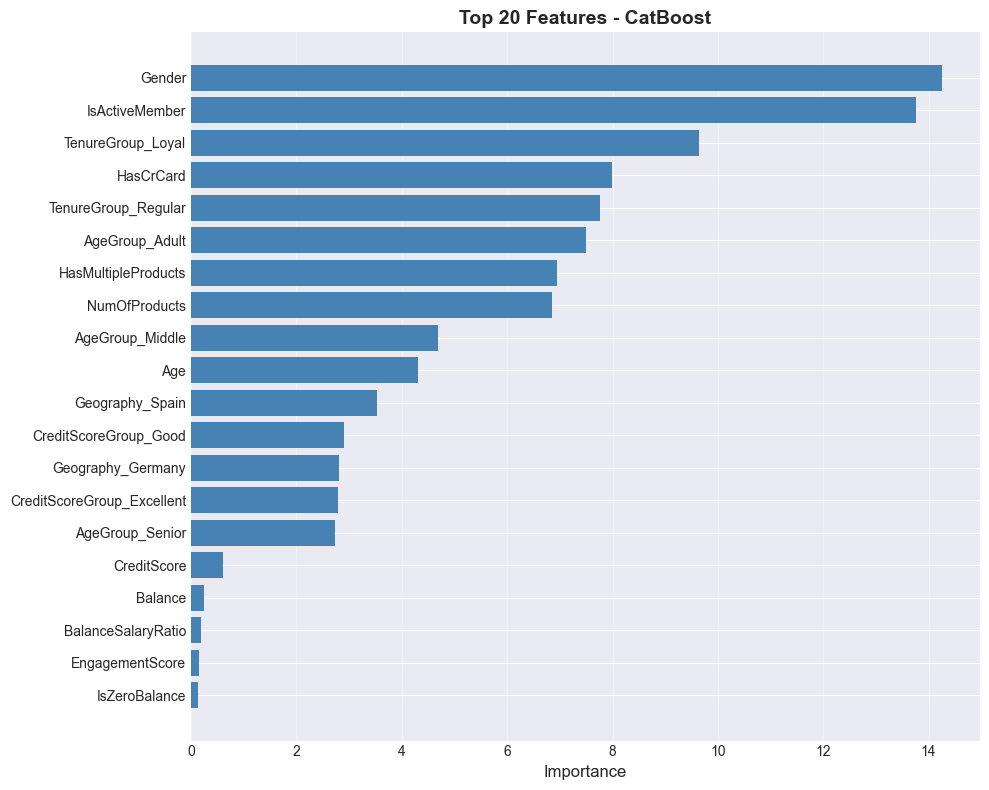

In [63]:
if CATBOOST_AVAILABLE:
    print("="*60)
    print("CATBOOST CLASSIFIER")
    print("="*60)
    
    cat_model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        l2_leaf_reg=3,
        random_state=42,
        verbose=0
    )
    
    print("\nEntrainement de CatBoost...")
    start_time = time.time()
    cat_model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    print(f"Temps d'entrainement: {train_time:.2f} secondes")
    
    # Evaluation
    cat_results = evaluate_model(
        cat_model, X_train, y_train, X_val, y_val,
        model_name="CatBoost"
    )
    
    print("\n--- RESULTATS CATBOOST ---")
    print(f"Train Accuracy: {cat_results['train_accuracy']:.4f}")
    print(f"Val Accuracy:   {cat_results['val_accuracy']:.4f}")
    print(f"Train F1:       {cat_results['train_f1']:.4f}")
    print(f"Val F1:         {cat_results['val_f1']:.4f}")
    print(f"Train ROC-AUC:  {cat_results['train_roc_auc']:.4f}")
    print(f"Val ROC-AUC:    {cat_results['val_roc_auc']:.4f}")
    
    all_results.append(cat_results)
    trained_models['CatBoost'] = cat_model
    
    # Feature importance
    cat_feature_imp = plot_feature_importance(
        cat_model, 
        X_train.columns, 
        top_n=20,
        model_name="CatBoost"
    )
else:
    print("CatBoost non disponible. Installation: pip install catboost")

### COMPARAISON DES MODELES

In [65]:
print("="*60)
print("COMPARAISON DES MODELES")
print("="*60)

COMPARAISON DES MODELES


In [67]:
# Creer le DataFrame de comparaison
comparison_df = compare_models(all_results)

# Trier par validation ROC-AUC
comparison_df = comparison_df.sort_values('val_roc_auc', ascending=False)

print("\nTableau de comparaison complet:")
display(comparison_df)


Tableau de comparaison complet:


,model_name,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc,overfit_accuracy,overfit_f1
4,LightGBM,0.915213,0.913135,0.944842,0.943853,0.881910,0.878531,0.912292,0.910021,0.971369,0.969419,0.002078,0.002271
2,Gradient Boosting,0.915410,0.912981,0.943751,0.943285,0.883476,0.878800,0.912619,0.909901,0.971115,0.969322,0.002429,0.002718
3,XGBoost,0.914973,0.912174,0.943071,0.941836,0.883264,0.878607,0.912188,0.909123,0.971289,0.969189,0.002799,0.003065
5,CatBoost,0.913887,0.911905,0.945328,0.944919,0.878586,0.874803,0.910736,0.908510,0.970132,0.968997,0.001982,0.002225
1,Random Forest,0.934249,0.912155,0.961942,0.941797,0.904275,0.878607,0.932217,0.909105,0.987279,0.968232,0.022095,0.023112
0,Logistic Regression,0.812739,0.813722,0.808045,0.811365,0.820357,0.817508,0.814155,0.814425,0.891256,0.890271,-0.000984,-0.000270


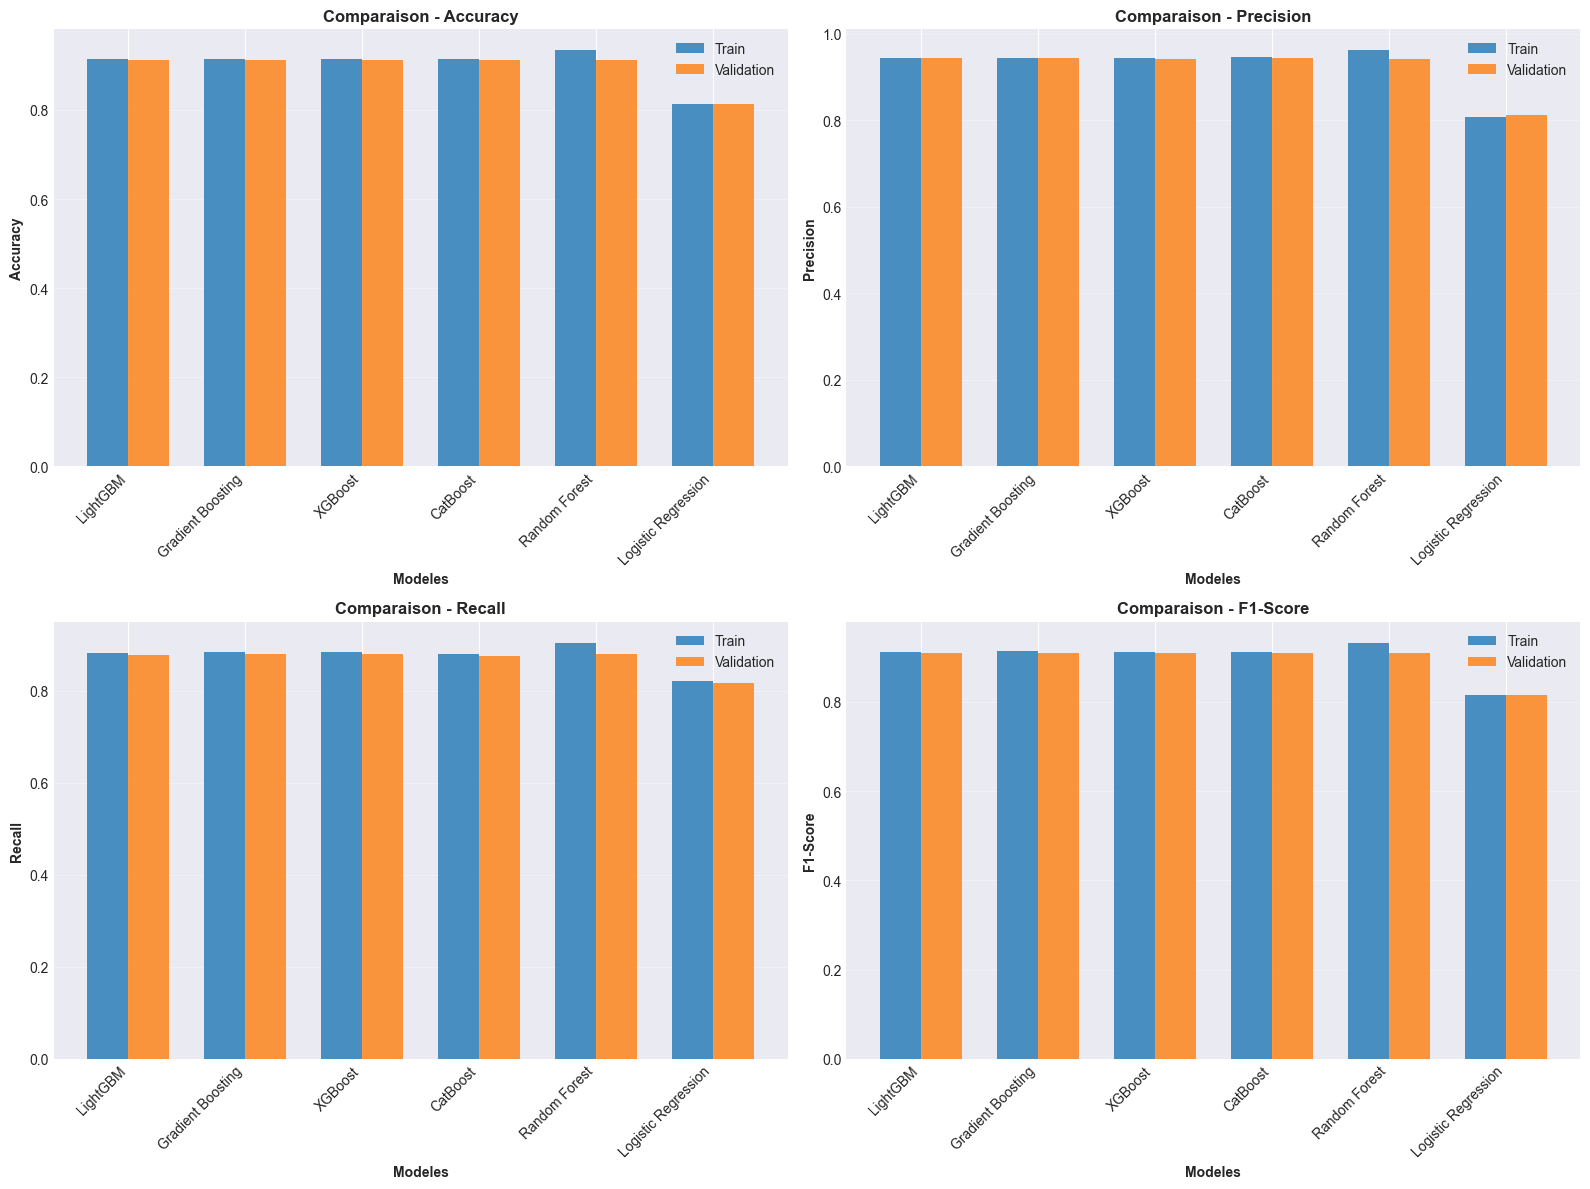

In [69]:
# Visualisation des performances
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['accuracy', 'precision', 'recall', 'f1']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    
    train_col = f'train_{metric}'
    val_col = f'val_{metric}'
    
    x = np.arange(len(comparison_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, comparison_df[train_col], width, 
                   label='Train', alpha=0.8)
    bars2 = ax.bar(x + width/2, comparison_df[val_col], width, 
                   label='Validation', alpha=0.8)
    
    ax.set_xlabel('Modeles', fontweight='bold')
    ax.set_ylabel(title, fontweight='bold')
    ax.set_title(f'Comparaison - {title}', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['model_name'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

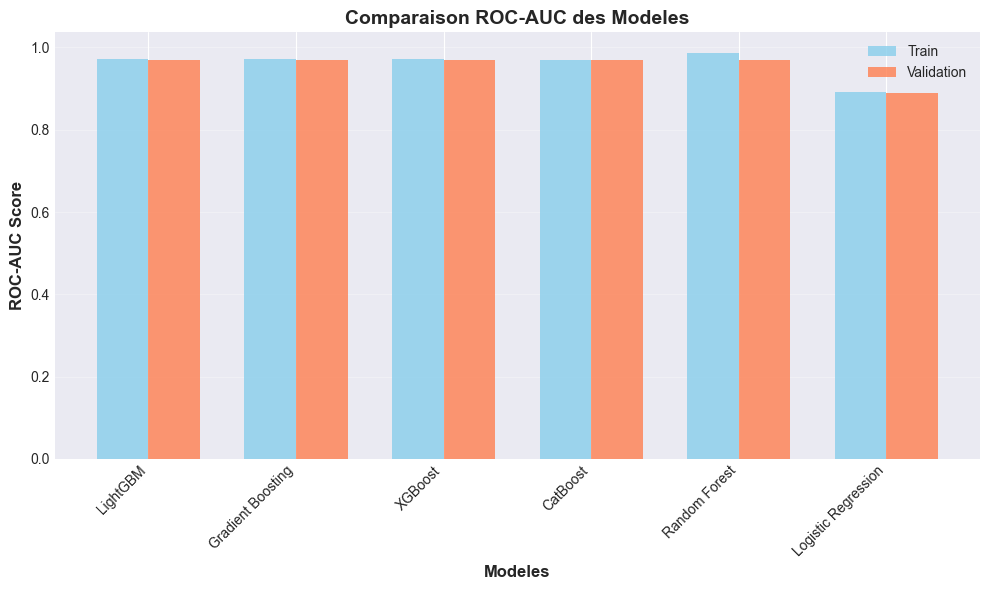

In [71]:
# Visualisation ROC-AUC
plt.figure(figsize=(10, 6))

train_roc = comparison_df['train_roc_auc']
val_roc = comparison_df['val_roc_auc']
models = comparison_df['model_name']

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, train_roc, width, label='Train', alpha=0.8, color='skyblue')
plt.bar(x + width/2, val_roc, width, label='Validation', alpha=0.8, color='coral')

plt.xlabel('Modeles', fontweight='bold', fontsize=12)
plt.ylabel('ROC-AUC Score', fontweight='bold', fontsize=12)
plt.title('Comparaison ROC-AUC des Modeles', fontsize=14, fontweight='bold')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [73]:
# Identifier le meilleur modele
best_model_name = comparison_df.iloc[0]['model_name']
best_model = trained_models[best_model_name]

print("="*60)
print(f"MEILLEUR MODELE: {best_model_name}")
print("="*60)

best_results = comparison_df.iloc[0]
print(f"\nValidation Accuracy:  {best_results['val_accuracy']:.4f}")
print(f"Validation Precision: {best_results['val_precision']:.4f}")
print(f"Validation Recall:    {best_results['val_recall']:.4f}")
print(f"Validation F1-Score:  {best_results['val_f1']:.4f}")
print(f"Validation ROC-AUC:   {best_results['val_roc_auc']:.4f}")

MEILLEUR MODELE: LightGBM

Validation Accuracy:  0.9131
Validation Precision: 0.9439
Validation Recall:    0.8785
Validation F1-Score:  0.9100
Validation ROC-AUC:   0.9694


### EVALUATION FINALE DU MEILLEUR MODELE

In [75]:
print("="*60)
print(f"OPTIMISATION DES HYPERPARAMETRES - {best_model_name}")
print("="*60)

OPTIMISATION DES HYPERPARAMETRES - LightGBM


#### RandomSearch

In [77]:
# Definir les grilles de parametres selon le modele
if best_model_name == "Logistic Regression":
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    }
    
elif best_model_name == "Random Forest":
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [2, 4, 6]
    }
    
elif best_model_name == "Gradient Boosting":
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_split': [10, 20, 30]
    }
    
elif best_model_name == "XGBoost":
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.7, 0.8, 0.9]
    }
    
elif best_model_name == "LightGBM":
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [5, 7, 10],
        'num_leaves': [31, 50, 70],
        'min_child_samples': [10, 20, 30]
    }
    
elif best_model_name == "CatBoost":
    param_grid = {
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5]
    }
else:
    param_grid = {}

In [79]:
# Nous utilisons RandomizedSearchCV pour une optimisation plus rapide
if param_grid:
    print(f"\nRecherche des meilleurs hyperparametres...")
    print(f"Grille de parametres: {len(param_grid)} parametres")
    
    # Creer un nouveau modele
    if best_model_name == "Logistic Regression":
        base_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    elif best_model_name == "Random Forest":
        base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    elif best_model_name == "Gradient Boosting":
        base_model = GradientBoostingClassifier(random_state=42)
    elif best_model_name == "XGBoost":
        base_model = xgb.XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')
    elif best_model_name == "LightGBM":
        base_model = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
    elif best_model_name == "CatBoost":
        base_model = CatBoostClassifier(random_state=42, verbose=0)
    
    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=20,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    print("\nDemarrage de l'optimisation...")
    start_time = time.time()
    random_search.fit(X_train, y_train)
    optimization_time = time.time() - start_time
    
    print(f"\nTemps d'optimisation: {optimization_time:.2f} secondes")
    print(f"\nMeilleurs parametres trouves:")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
    
    # Modele optimise
    optimized_model = random_search.best_estimator_
    
    # Evaluation du modele optimise
    optimized_results = evaluate_model(
        optimized_model, X_train, y_train, X_val, y_val,
        model_name=f"{best_model_name} (Optimized)"
    )
    
    print("\n--- RESULTATS APRES OPTIMISATION ---")
    print(f"Val Accuracy:  {optimized_results['val_accuracy']:.4f} (avant: {best_results['val_accuracy']:.4f})")
    print(f"Val Precision: {optimized_results['val_precision']:.4f} (avant: {best_results['val_precision']:.4f})")
    print(f"Val Recall:    {optimized_results['val_recall']:.4f} (avant: {best_results['val_recall']:.4f})")
    print(f"Val F1-Score:  {optimized_results['val_f1']:.4f} (avant: {best_results['val_f1']:.4f})")
    print(f"Val ROC-AUC:   {optimized_results['val_roc_auc']:.4f} (avant: {best_results['val_roc_auc']:.4f})")
    
    # Comparer avant/apres
    improvement = {
        'Accuracy': optimized_results['val_accuracy'] - best_results['val_accuracy'],
        'Precision': optimized_results['val_precision'] - best_results['val_precision'],
        'Recall': optimized_results['val_recall'] - best_results['val_recall'],
        'F1-Score': optimized_results['val_f1'] - best_results['val_f1'],
        'ROC-AUC': optimized_results['val_roc_auc'] - best_results['val_roc_auc']
    }
    
    print("\n--- AMELIORATION ---")
    for metric, value in improvement.items():
        sign = "+" if value >= 0 else ""
        print(f"{metric:12s}: {sign}{value:.4f}")
    
    # Utiliser le modele optimise si meilleur
    if optimized_results['val_roc_auc'] > best_results['val_roc_auc']:
        best_model = optimized_model
        print(f"\nModele optimise retenu (ROC-AUC ameliore)")
    else:
        print(f"\nModele original retenu (pas d'amelioration)")
else:
    print("Pas de grille de parametres definie pour ce modele")
    optimized_model = best_model


Recherche des meilleurs hyperparametres...
Grille de parametres: 5 parametres

Demarrage de l'optimisation...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Temps d'optimisation: 315.38 secondes

Meilleurs parametres trouves:
  num_leaves: 50
  n_estimators: 200
  min_child_samples: 20
  max_depth: 5
  learning_rate: 0.1

--- RESULTATS APRES OPTIMISATION ---
Val Accuracy:  0.9133 (avant: 0.9131)
Val Precision: 0.9446 (avant: 0.9439)
Val Recall:    0.8781 (avant: 0.8785)
Val F1-Score:  0.9102 (avant: 0.9100)
Val ROC-AUC:   0.9696 (avant: 0.9694)

--- AMELIORATION ---
Accuracy    : +0.0002
Precision   : +0.0008
Recall      : -0.0004
F1-Score    : +0.0001
ROC-AUC     : +0.0002

Modele optimise retenu (ROC-AUC ameliore)


### EVALUATION FINALE DU MEILLEUR MODELE

In [81]:
print("="*60)
print("EVALUATION FINALE DU MEILLEUR MODELE")
print("="*60)

EVALUATION FINALE DU MEILLEUR MODELE


In [83]:
# Predictions sur validation
y_val_pred_final = best_model.predict(X_val)
y_val_proba_final = best_model.predict_proba(X_val)[:, 1]
y_val_pred_final
y_val_proba_final

array([0.00727611, 0.04754406, 0.05154104, ..., 0.69584495, 0.86263101,
       0.01834516])

In [85]:
# Rapport de classification complet
print("\n--- RAPPORT DE CLASSIFICATION ---")
print(classification_report(y_val, y_val_pred_final, 
                          target_names=['Reste (0)', 'Parti (1)']))


--- RAPPORT DE CLASSIFICATION ---
              precision    recall  f1-score   support

   Reste (0)       0.89      0.95      0.92     26023
   Parti (1)       0.94      0.88      0.91     26023

    accuracy                           0.91     52046
   macro avg       0.92      0.91      0.91     52046
weighted avg       0.92      0.91      0.91     52046



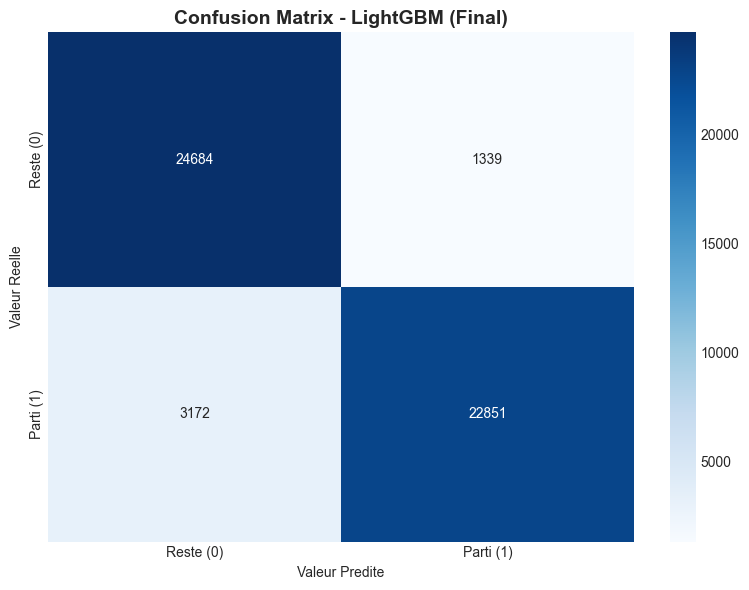

In [87]:
# Matrice de confusion finale
plot_confusion_matrix(y_val, y_val_pred_final, 
                     title=f"Confusion Matrix - {best_model_name} (Final)")

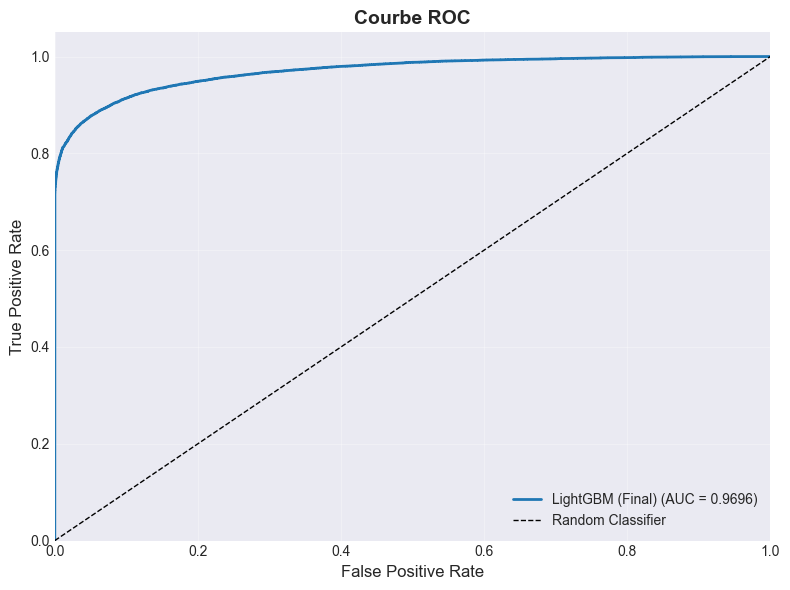

In [89]:
# Courbe ROC finale
plot_roc_curve(y_val, y_val_proba_final, 
              model_name=f"{best_model_name} (Final)")

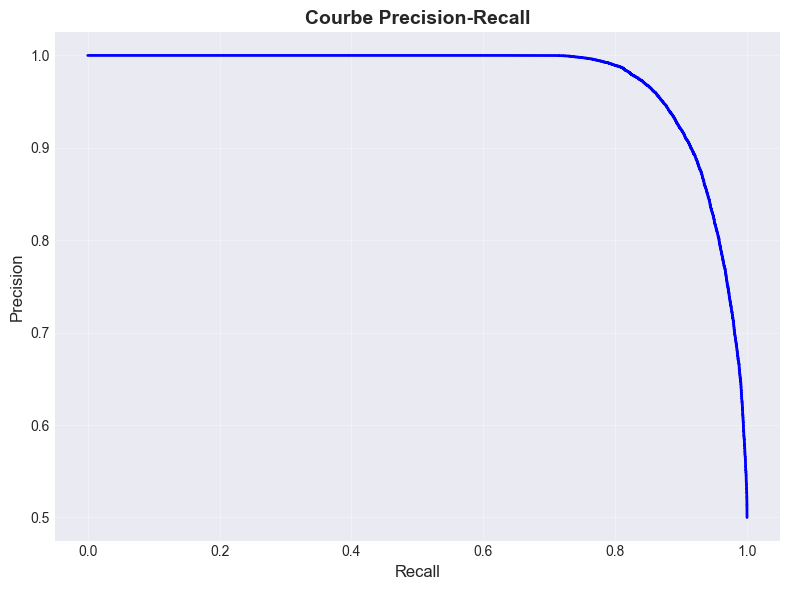

In [91]:
# Courbe Precision-Recall
precision_vals, recall_vals, thresholds = precision_recall_curve(y_val, y_val_proba_final)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, linewidth=2, color='blue')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Courbe Precision-Recall', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

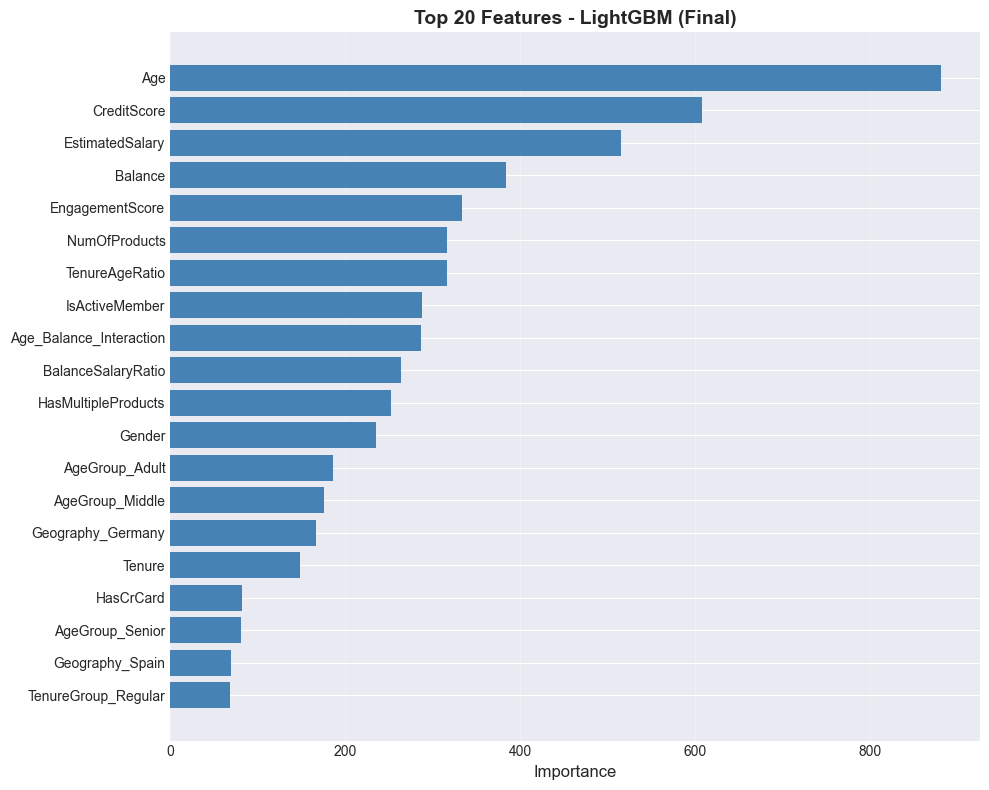


Top 15 Features les plus importantes:


,feature,importance
2,Age,882
0,CreditScore,608
8,EstimatedSalary,515
4,Balance,384
12,EngagementScore,334
5,NumOfProducts,317
14,TenureAgeRatio,317
7,IsActiveMember,288
13,Age_Balance_Interaction,287
9,BalanceSalaryRatio,264


In [93]:
# Feature importance finale
if hasattr(best_model, 'feature_importances_') or hasattr(best_model, 'coef_'):
    final_feature_imp = plot_feature_importance(
        best_model, 
        X_train.columns, 
        top_n=20,
        model_name=f"{best_model_name} (Final)"
    )
    
    print("\nTop 15 Features les plus importantes:")
    display(final_feature_imp.head(15))

### CROSS-VALIDATION

In [95]:
print("="*60)
print("CROSS-VALIDATION")
print("="*60)

CROSS-VALIDATION


In [97]:
# Combiner train et val pour la cross-validation
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

print(f"\nDataset complet pour CV: {X_full.shape}")


Dataset complet pour CV: (260226, 24)


In [105]:
# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"\nCross-validation avec {cv.n_splits} folds...")


Cross-validation avec 5 folds...


In [101]:
# Scores
cv_scores = {
    'accuracy': cross_val_score(best_model, X_full, y_full, cv=cv, scoring='accuracy', n_jobs=-1),
    'precision': cross_val_score(best_model, X_full, y_full, cv=cv, scoring='precision', n_jobs=-1),
    'recall': cross_val_score(best_model, X_full, y_full, cv=cv, scoring='recall', n_jobs=-1),
    'f1': cross_val_score(best_model, X_full, y_full, cv=cv, scoring='f1', n_jobs=-1),
    'roc_auc': cross_val_score(best_model, X_full, y_full, cv=cv, scoring='roc_auc', n_jobs=-1)
}

In [107]:
# Afficher les resultats
print("\n--- RESULTATS CROSS-VALIDATION ---")
for metric, scores in cv_scores.items():
    print(f"\n{metric.upper()}:")
    print(f"  Scores: {[f'{s:.4f}' for s in scores]}")
    print(f"  Moyenne: {scores.mean():.4f}")
    print(f"  Std Dev: {scores.std():.4f}")


--- RESULTATS CROSS-VALIDATION ---

ACCURACY:
  Scores: ['0.9136', '0.9155', '0.9130', '0.9137', '0.9154']
  Moyenne: 0.9143
  Std Dev: 0.0010

PRECISION:
  Scores: ['0.9435', '0.9437', '0.9422', '0.9454', '0.9425']
  Moyenne: 0.9435
  Std Dev: 0.0011

RECALL:
  Scores: ['0.8799', '0.8837', '0.8800', '0.8783', '0.8848']
  Moyenne: 0.8813
  Std Dev: 0.0025

F1:
  Scores: ['0.9106', '0.9127', '0.9100', '0.9106', '0.9127']
  Moyenne: 0.9113
  Std Dev: 0.0011

ROC_AUC:
  Scores: ['0.9700', '0.9700', '0.9690', '0.9699', '0.9708']
  Moyenne: 0.9699
  Std Dev: 0.0006


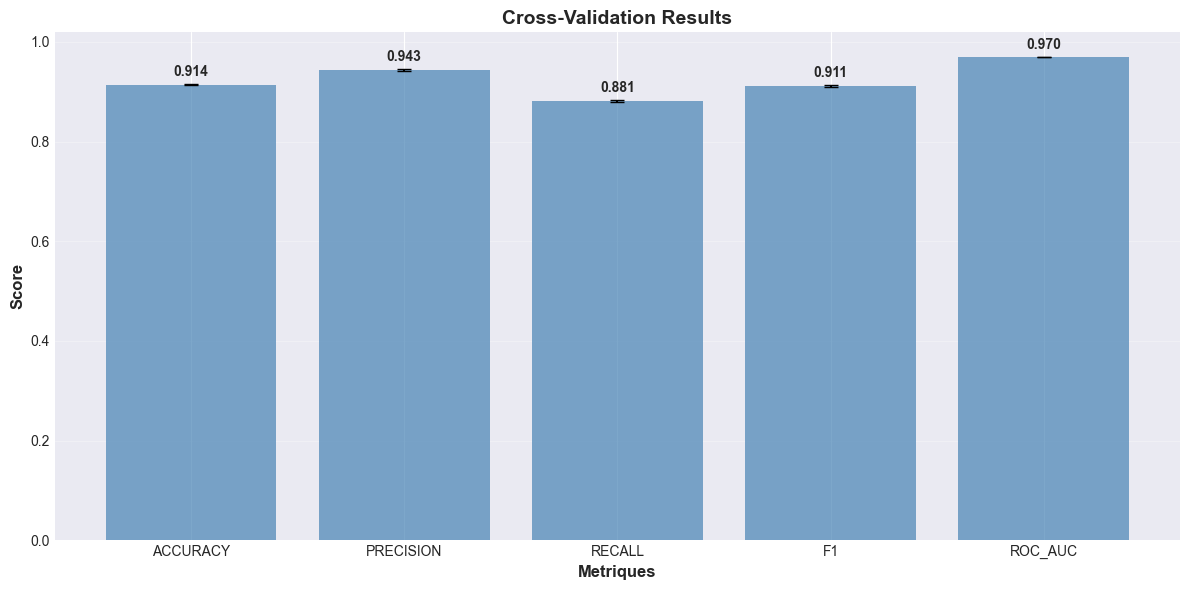

In [109]:
# Visualisation des scores CV
fig, ax = plt.subplots(figsize=(12, 6))

metrics_names = list(cv_scores.keys())
means = [cv_scores[m].mean() for m in metrics_names]
stds = [cv_scores[m].std() for m in metrics_names]

x = np.arange(len(metrics_names))
bars = ax.bar(x, means, yerr=stds, capsize=5, alpha=0.7, color='steelblue')

ax.set_xlabel('Metriques', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
ax.set_title('Cross-Validation Results', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in metrics_names])
ax.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for i, (mean, std) in enumerate(zip(means, stds)):
    ax.text(i, mean + std + 0.01, f'{mean:.3f}', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### SAUVEGARDE DU MODELE FINAL

In [111]:
print("="*60)
print("SAUVEGARDE DU MODELE FINAL")
print("="*60)

SAUVEGARDE DU MODELE FINAL


In [113]:
# Creer le dossier models s'il n'existe pas
models_path = base_path / 'models' / 'saved_models'
models_path.mkdir(parents=True, exist_ok=True)

In [115]:
# Nom du fichier
model_filename = f"best_model_{best_model_name.lower().replace(' ', '_')}.pkl"
model_path = models_path / model_filename

In [117]:
# Sauvegarder le modele
joblib.dump(best_model, model_path)
print(f"\nModele sauvegarde: {model_path}")


Modele sauvegarde: C:\Users\Easy Services Pro\Projet_Machine_Learning2\models\saved_models\best_model_lightgbm.pkl


In [119]:
# Sauvegarder aussi les resultats
results_filename = f"model_results_{best_model_name.lower().replace(' ', '_')}.pkl"
results_path = models_path / results_filename

results_to_save = {
    'model_name': best_model_name,
    'best_params': random_search.best_params_ if 'random_search' in locals() else None,
    'validation_metrics': optimized_results if 'optimized_results' in locals() else best_results,
    'cv_scores': cv_scores,
    'feature_importance': final_feature_imp if 'final_feature_imp' in locals() else None,
    'all_models_comparison': comparison_df
}

joblib.dump(results_to_save, results_path)
print(f"Resultats sauvegardes: {results_path}")

Resultats sauvegardes: C:\Users\Easy Services Pro\Projet_Machine_Learning2\models\saved_models\model_results_lightgbm.pkl


In [121]:
# Sauvegarder aussi les comparaisons
comparison_df.to_csv(models_path / 'models_comparison.csv', index=False)
print(f"Comparaison sauvegardee: {models_path / 'models_comparison.csv'}")

Comparaison sauvegardee: C:\Users\Easy Services Pro\Projet_Machine_Learning2\models\saved_models\models_comparison.csv


### RESUME FINAL

In [123]:
print("="*80)
print("RESUME FINAL DU PROJET")
print("="*80)

RESUME FINAL DU PROJET


In [125]:
print(f"""
MODELE SELECTIONNE: {best_model_name}

PERFORMANCES SUR VALIDATION:
  - Accuracy:  {optimized_results['val_accuracy'] if 'optimized_results' in locals() else best_results['val_accuracy']:.4f}
  - Precision: {optimized_results['val_precision'] if 'optimized_results' in locals() else best_results['val_precision']:.4f}
  - Recall:    {optimized_results['val_recall'] if 'optimized_results' in locals() else best_results['val_recall']:.4f}
  - F1-Score:  {optimized_results['val_f1'] if 'optimized_results' in locals() else best_results['val_f1']:.4f}
  - ROC-AUC:   {optimized_results['val_roc_auc'] if 'optimized_results' in locals() else best_results['val_roc_auc']:.4f}

CROSS-VALIDATION (5-Fold):
  - ROC-AUC: {cv_scores['roc_auc'].mean():.4f} (+/- {cv_scores['roc_auc'].std():.4f})
  - F1-Score: {cv_scores['f1'].mean():.4f} (+/- {cv_scores['f1'].std():.4f})

NOMBRE DE MODELES TESTES: {len(all_results)}

FICHIERS SAUVEGARDES:
  - Modele: {model_path}
  - Resultats: {results_path}
  - Comparaison: {models_path / 'models_comparison.csv'}

PROCHAINES ETAPES:
  1. Tester sur le test set
  2. Analyser les erreurs de prediction
  3. Deploiement du modele
  4. Monitoring en production
""")


MODELE SELECTIONNE: LightGBM

PERFORMANCES SUR VALIDATION:
  - Accuracy:  0.9133
  - Precision: 0.9446
  - Recall:    0.8781
  - F1-Score:  0.9102
  - ROC-AUC:   0.9696

CROSS-VALIDATION (5-Fold):
  - ROC-AUC: 0.9699 (+/- 0.0006)
  - F1-Score: 0.9113 (+/- 0.0011)

NOMBRE DE MODELES TESTES: 6

FICHIERS SAUVEGARDES:
  - Modele: C:\Users\Easy Services Pro\Projet_Machine_Learning2\models\saved_models\best_model_lightgbm.pkl
  - Resultats: C:\Users\Easy Services Pro\Projet_Machine_Learning2\models\saved_models\model_results_lightgbm.pkl
  - Comparaison: C:\Users\Easy Services Pro\Projet_Machine_Learning2\models\saved_models\models_comparison.csv

PROCHAINES ETAPES:
  1. Tester sur le test set
  2. Analyser les erreurs de prediction
  3. Deploiement du modele
  4. Monitoring en production



In [127]:
print("="*80)
print("MODELISATION TERMINEE AVEC SUCCES!")
print("="*80)

MODELISATION TERMINEE AVEC SUCCES!
